## 1. Descarga y exploración del corpus

In [2]:
# Importo las librerías necesarias para la descarga de la base de datos

import json
import gzip
import pandas as pd

In [2]:
# Descargo la base de datos desde el drive con gzip

with gzip.open('Video_Games_5.json.gz', 'rb') as f:
  df = pd.read_json(f, lines=True)

# Decido balancear las muestras de la base de datos para reviews positivas (5 y 4) y negativas (1 y 2) con 10.000 muestras para cada puntuación

filtered_df = df[df['overall'].isin([1, 2, 4, 5])]
num_samples = 10000
sampled_df_1 = filtered_df[filtered_df['overall'] == 1].sample(n=num_samples, random_state=1)
sampled_df_2 = filtered_df[filtered_df['overall'] == 2].sample(n=num_samples, random_state=1)
sampled_df_4 = filtered_df[filtered_df['overall'] == 4].sample(n=num_samples, random_state=1)
sampled_df_5 = filtered_df[filtered_df['overall'] == 5].sample(n=num_samples, random_state=1)
result_df = pd.concat([sampled_df_1, sampled_df_2, sampled_df_4, sampled_df_5])

# Guardo la base de datos balanceada en formato csv

result_df.to_csv('sampled_data_file.csv', index=False)

In [7]:
# Abro la base de datos balanceada y cargo dataframe sólo con los campos objeto de análisis ('overall' y 'reviewText'), visualizo 5 primeras reviews

result_df = pd.read_csv("sampled_data_file.csv", sep=',')

df_videogames = result_df.loc[:,['overall', 'reviewText']]

df_videogames.head(5)

,overall,reviewText
0,1,This game could have been so much more. The h...
1,1,"THIS TOP PARAGRAPH IS AN ADDED EDIT, EVERYTHIN..."
2,1,I have used many third party expansion packs a...
3,1,These gloves must have been made before the ga...
4,1,I love the Thief franchise. I played Thief th...


In [9]:
# Compruebo si hay valores nulos

df_videogames.isnull().sum()

# Elimino los valores nulos

df_videogames.dropna(inplace=True)

# Comprueblo, tras las eliminaciones de valores nulos, el balanceo de la base de datos

df_videogames['overall'].value_counts()

# Hay un ligerísimo desbalanceo que considero asumible

2    9999
4    9999
1    9998
5    9995
Name: overall, dtype: int64

In [10]:
# Agrupo las reviews positivas (5 y 4 -> 1) y negativas (1 y 2 -> 0) en una nueva variable ('sentiment_label')

sentiment_label = []

for p in df_videogames['overall']:
  if p < 3:
    sentiment_label.append(0)
  else:
    sentiment_label.append(1)

sentiment_label = pd.Series(sentiment_label)
df_videogames['sentiment_label'] = sentiment_label

# Elimino la variable 'overall'

df_videogames = df_videogames.drop('overall', axis=1)

# Llegado a este punto considero que el dataframe está listo para su exploración, lo guardo en formato csv para posteriores usos

df_videogames.to_csv('df_videogames.csv', index=False)

In [13]:
# Comienzo la exploración observando la distribución de reviews por sentimiento

df_videogames['sentiment_label'].value_counts()



0.0    19994
1.0    19988
Name: sentiment_label, dtype: int64

In [19]:
# Observo la cardinalidad del vocabulario

from collections import Counter

splitted_reviews = df_videogames['reviewText'].str.lower().str.split()
words = splitted_reviews.apply(pd.Series).stack().reset_index(drop = True)
vocabulary = Counter(words)
len(vocabulary)

174474

In [23]:
# Observo las 20 palabras más frecuentes

vocabulary.most_common(20)

# Compruebo que esas 20 palabras más frecuentes no aportan nada al análisis, lo que señala la necesidad de eliminar stopwords

[('the', 314883),
 ('and', 154518),
 ('to', 154405),
 ('a', 141758),
 ('i', 113712),
 ('of', 108737),
 ('is', 97502),
 ('you', 90738),
 ('it', 82171),
 ('this', 75145),
 ('game', 69333),
 ('in', 66045),
 ('that', 59806),
 ('for', 57227),
 ('but', 45136),
 ('are', 43126),
 ('with', 42727),
 ('on', 39733),
 ('have', 39260),
 ('not', 35057)]

In [24]:
# Genero los bigramas y trigramas del corpus

!pip install nltk
from nltk import ngrams
from nltk.probability import FreqDist

bigrams = list(ngrams(words, 2))
trigrams = list(ngrams(words, 3))

# Obtengo las frecuencias de los distintos bigramas y trigramas

bg_freq = FreqDist(bigrams)
tg_freq = FreqDist(trigrams)

# Observo los 20 bigramas más frecuentes

bg_freq.most_common(20)

[(('of', 'the'), 28999),
 (('the', 'game'), 23673),
 (('this', 'game'), 21128),
 (('in', 'the'), 17841),
 (('if', 'you'), 13254),
 (('to', 'the'), 12074),
 (('is', 'a'), 11968),
 (('on', 'the'), 11925),
 (('and', 'the'), 11250),
 (('you', 'can'), 11120),
 (('game', 'is'), 10284),
 (('this', 'is'), 10221),
 (('for', 'the'), 10133),
 (('it', 'is'), 9019),
 (('with', 'the'), 8847),
 (('to', 'be'), 8724),
 (('i', 'have'), 7662),
 (('have', 'to'), 7470),
 (('you', 'have'), 6861),
 (('is', 'the'), 6734)]

In [25]:
# Observo los 20 trigramas más frecuentes

tg_freq.most_common(20)

# La observación de los bigramas y trigramas más frecuentes apunta en la misma dirección que la observación de las palabras más frecuentes: la necesidad de eliminar stopwords

[(('this', 'game', 'is'), 5413),
 (('a', 'lot', 'of'), 3870),
 (('the', 'game', 'is'), 3865),
 (('you', 'have', 'to'), 3250),
 (('one', 'of', 'the'), 2978),
 (('this', 'is', 'a'), 2625),
 (('of', 'the', 'game'), 2356),
 (('some', 'of', 'the'), 2063),
 (('the', 'graphics', 'are'), 2038),
 (('if', 'you', 'are'), 1673),
 (('there', 'is', 'no'), 1521),
 (('in', 'the', 'game'), 1484),
 (('you', 'want', 'to'), 1413),
 (('this', 'is', 'the'), 1394),
 (('if', 'you', 'want'), 1392),
 (('there', 'is', 'a'), 1310),
 (('most', 'of', 'the'), 1302),
 (('it', 'is', 'a'), 1292),
 (('if', 'you', 'have'), 1275),
 (('in', 'this', 'game'), 1273)]

In [36]:
# Decido comprobar cómo quedarían las palabras, bigramas y trigramas más frecuentes eliminando las stopwords
# En primer lugar obtengo las stopwords en inglés
!pip install stop-words
from stop_words import get_stop_words

sw_list = get_stop_words('en')

# Elimino las stopwords del vocabulario y calculo de nuevo las palabras más frecuentes

words_cleaned = []

for w in words:
  if w not in sw_list:
    words_cleaned.append(w)
  else:
    pass

vocabulary_cleaned = Counter(words_cleaned)
vocabulary_cleaned.most_common(20)

# Observo que, eliminando las stopwords, las palabras más frecuentes del corpus son ahora más adecuadas para el análisis. Detecto, además, que debo eliminar las palabras derivadas de game
# ('game', 'games', 'game.') por encontrarse entr las más frecuentes y no aportar nada al análisis.

[('game', 69333),
 ('like', 25952),
 ('just', 23985),
 ('can', 22830),
 ('get', 20165),
 ('one', 19563),
 ('will', 16820),
 ('play', 15676),
 ('games', 15118),
 ('game.', 14065),
 ('really', 14056),
 ('even', 13177),
 ('good', 12910),
 ('much', 11079),
 ('time', 10213),
 ('great', 10082),
 ('first', 9733),
 ('it.', 9560),
 ('-', 9320),
 ('also', 8948)]

In [37]:
# Termino con las comprobaciones, sin stopwords, para bigramas y trigramas

bigrams_cleaned = list(ngrams(words_cleaned, 2))
trigrams_cleaned = list(ngrams(words_cleaned, 3))

bgcleaned_freq = FreqDist(bigrams_cleaned)
tgcleaned_freq = FreqDist(trigrams_cleaned)

bgcleaned_freq.most_common(20)

[(('game', 'play'), 1508),
 (('feel', 'like'), 1209),
 (('can', 'get'), 1206),
 (('play', 'game'), 1163),
 (('pretty', 'much'), 1097),
 (('game', 'just'), 1072),
 (('single', 'player'), 1031),
 (('game', 'will'), 955),
 (('can', 'play'), 936),
 (('even', 'though'), 929),
 (('feels', 'like'), 912),
 (('final', 'fantasy'), 897),
 (('great', 'game'), 840),
 (('xbox', '360'), 825),
 (('video', 'game'), 825),
 (('good', 'game'), 818),
 (('just', 'like'), 810),
 (('playing', 'game'), 806),
 (('much', 'better'), 804),
 (('game', 'really'), 764)]

In [38]:
# Tras los bigramas, compruebo ahora cómo quedan sin stopwords los trigramas

tgcleaned_freq.most_common(20)

# Concluyo que, eliminando stopwords, las palabras, bigramas y trigramas del corpus ganan en capacidad de análisis

[(('one', 'best', 'games'), 179),
 (('first', 'person', 'shooter'), 150),
 (('grand', 'theft', 'auto'), 149),
 (('metal', 'gear', 'solid'), 131),
 (('.', '.', '.'), 116),
 (('game', 'ever', 'played.'), 113),
 (('single', 'player', 'campaign'), 106),
 (('really', 'wanted', 'like'), 99),
 (('games', 'ever', 'played.'), 98),
 (('one', 'worst', 'games'), 88),
 (('game', 'feels', 'like'), 87),
 (('devil', 'may', 'cry'), 86),
 (('makes', 'feel', 'like'), 83),
 (('single', 'player', 'game'), 81),
 (('super', 'mario', 'bros.'), 78),
 (('let', 'start', 'saying'), 77),
 (('single', 'player', 'mode'), 71),
 (('will', 'never', 'buy'), 70),
 (('really', 'looking', 'forward'), 70),
 (('resident', 'evil', '4'), 70)]

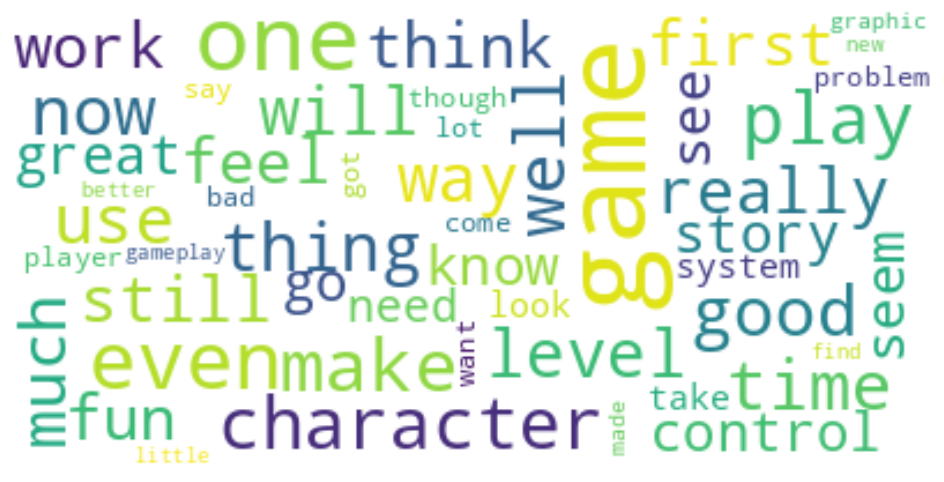

In [44]:
# Para finalizar la exploración genero un wordcloud con las 50 palabras más comunes del corpus (sin stopwords)
!pip install wordcloud

import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white").generate(' '.join(words_cleaned))
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Conclusiones

La exploración del dataframe permite concluir que el corpus, para un análisis más eficiente, necesita de una limpieza de stopwords, otros términos frecuentes que no aportan nada al análisis (derivados de 'game') y signos de puntuación que sólo generan "ruido". Sin la observación de palabras, bigramas y trigramas más frecuentes no se podría haber identificado ese "ruido" ni orientado la limpieza del corpus.